In [ ]:
#!pip install keras-segmentation

In [1]:
import os

from tensorflow.keras.losses import BinaryCrossentropy

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np

from tensorflow.keras import Model
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import BinaryCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing

In [2]:
img_list = os.listdir('./Brain Tumor Data Set')
img_list

['Brain Tumor', 'Healthy']

In [3]:
tumor_dir = './Brain Tumor Data Set/Brain Tumor'
healthy_dir = './Brain Tumor Data Set/Healthy'

filepaths = []
labels = []
folder_name = [tumor_dir, healthy_dir]

for i, j in enumerate(folder_name):
    title = os.listdir(j)
    for t in title:
        fpath = os.path.join(j, t)
        filepaths.append(fpath)
        if i == 0:
            labels.append('cancer')
        else:
            labels.append('healthy')

Fseries = pd.Series(filepaths, name='filepaths')
label = pd.Series(labels, name='labels')

tumor_data = pd.concat([Fseries, label], axis=1)
tumor_df = pd.DataFrame(tumor_data)
print(tumor_data)

                                              filepaths   labels
0     ./Brain Tumor Data Set/Brain Tumor\Cancer (1).jpg   cancer
1     ./Brain Tumor Data Set/Brain Tumor\Cancer (1).png   cancer
2     ./Brain Tumor Data Set/Brain Tumor\Cancer (1).tif   cancer
3     ./Brain Tumor Data Set/Brain Tumor\Cancer (10)...   cancer
4     ./Brain Tumor Data Set/Brain Tumor\Cancer (10)...   cancer
...                                                 ...      ...
4595  ./Brain Tumor Data Set/Healthy\Not Cancer  (99...  healthy
4596  ./Brain Tumor Data Set/Healthy\Not Cancer  (99...  healthy
4597  ./Brain Tumor Data Set/Healthy\Not Cancer  (99...  healthy
4598  ./Brain Tumor Data Set/Healthy\Not Cancer  (99...  healthy
4599  ./Brain Tumor Data Set/Healthy\Not Cancer  (99...  healthy

[4600 rows x 2 columns]


In [4]:
tumor_df['labels'].value_counts()

cancer     2513
healthy    2087
Name: labels, dtype: int64

In [5]:
train_img, test_img = train_test_split(tumor_df,test_size=.25, random_state=42)
train_set, val_set = train_test_split(train_img, test_size=.25, random_state=42)

train_set.shape, val_set.shape, test_img.shape

((2587, 2), (863, 2), (1150, 2))

In [27]:
generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
                              zoom_range=0.2, horizontal_flip=True, width_shift_range=0.05, height_shift_range=0.05)

train = generator.flow_from_dataframe(dataframe=train_set, x_col='filepaths', y_col='labels',
                                     target_size=(128,128),
                                     color_mode='rgb',
                                     class_mode='binary',
                                     batch_size=16,
                                     shuffle=True)

test = generator.flow_from_dataframe(dataframe=test_img, x_col='filepaths', y_col ='labels',
                                    target_size=(128,128),
                                    color_mode='rgb',
                                    class_mode='binary',
                                    bath_size=16,
                                    shuffle=False)

val = generator.flow_from_dataframe(dataframe=val_set, x_col='filepaths', y_col='labels',
                                   target_size=(128,128),
                                   color_mode='rgb',
                                   class_mode='binary',
                                   batch_size=16,
                                   shuffle=False)

Found 2587 validated image filenames belonging to 2 classes.
Found 1150 validated image filenames belonging to 2 classes.
Found 863 validated image filenames belonging to 2 classes.


In [36]:
train.image_shape

(128, 128, 3)

In [29]:
def show_brain_images(generated):
    train_dict = train.class_indices # 클래스 이름 불러오기 -> dictionary
    class_names = list(train_dict.keys()) # dictionary 값을 list로 변환
    images, labels = next(generated) # 제목 제외하고 값만 가져오기 
    
    plt.figure(figsize=(16,16))
    length = len(labels)
    
    if length < 15:
        n = length
    else:
        n = 15
    
    for i in range(n):
        plt.subplot(5, 5, i+1)
        
        image=(images[i]+1) / 2 # scale images
        plt.imshow(image)
        
        index=np.argmax(labels[i])
        class_name = class_names[index]
        plt.title(class_name, color='k', fontsize=16)
        plt.axis('off')
    plt.show()

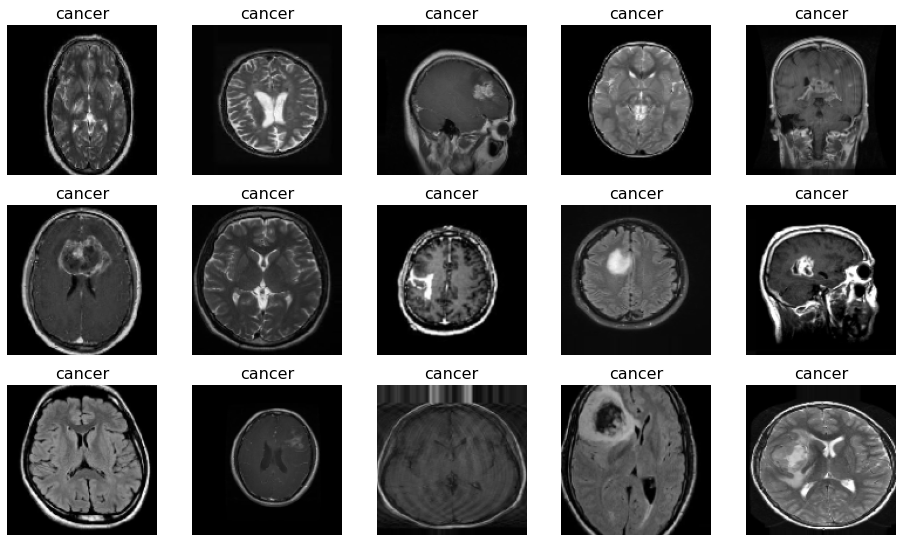

In [50]:
show_brain_images(val)

In [31]:
model = Sequential()
# img_input = Input(shape=(244, 244, 3))
model.add(Conv2D(32, (3, 3), strides=1, activation='relu', padding='same', input_shape=(244, 244, 3)))#(img_input)
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (3, 3), strides=1, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

In [44]:
callback = tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=2,
                                 verbose=0, mode='auto', restore_best_weights=True )

In [ ]:
history = model.fit(train, validation_data=val, epochs=30, verbose=1,callbacks=[callback])

In [ ]:
model.evaluate(test, verbose=1)

In [ ]:
pred = model.predict(test)

y_pred = [round(x[0]) for x in pred]

labels = (train.class_indices)
labels = dict((v,k) for k, v in labels.items())
pred2 = [labels[k] for k in y_pred]

y_test = test_img.labels

print(classification_report(pred2, y_test))

In [ ]:
labels = dict((v,k) for k, v in labels.items())
labels